# Anomaly Correlation Coefficient

[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ai_weather_to_climate_ats780A8/tree/main/lecture_code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/ai_weather_to_climate_ats780A8/blob/main/lecture_code/acc.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_rednoise(N, tau, var=1):
    """
    Create a red noise time series of length N with a given decorrelation time tau.
    """
    # create red-noise time series iteratively
    a = np.exp(-1.0 / tau)
    b = np.sqrt(1.0 - a**2)
    x = []
    x.append(
        np.random.normal(
            0.0,
            1.0,
            size=1,
        )
    )
    for it in np.arange(0, N - 1, 1):
        x.append(a * x[it] + b * np.random.normal(size=1))
    x = np.asarray(x)[:, 0]
    return x * np.sqrt(var / np.var(x))


def create_ensemble(N, tau, nens=1000, var=1):
    """
    Create an ensemble of red noise time series.
    """
    ensemble = np.empty((nens, N))
    for i in range(nens):
        ensemble[i,:] = create_rednoise(N, tau, var)
    return ensemble

def add_trend(data, trend=0):
    """
    Add a linear trend to the data.
    """
    x = np.arange(0, data.shape[-1], 1)
    return data + trend * x

def add_seasonal_cycle(data, period=12, amplitude=3):
    """
    Add a seasonal cycle to the data.
    """
    x = np.arange(0, data.shape[-1], 1)
    return data + amplitude * np.sin(2 * np.pi * x / period) + 287

def remove_seasonal_cycle(data, period=12):
    """
    Remove a seasonal cycle from the data.
    """
    data_anom = np.empty_like(data)
    for m in range(period):
        for ens in range(data.shape[0]):
            data_anom[ens, m::period] = data[ens, m::period] - np.mean(data[:, m::period], axis=(0,1))
    return data_anom

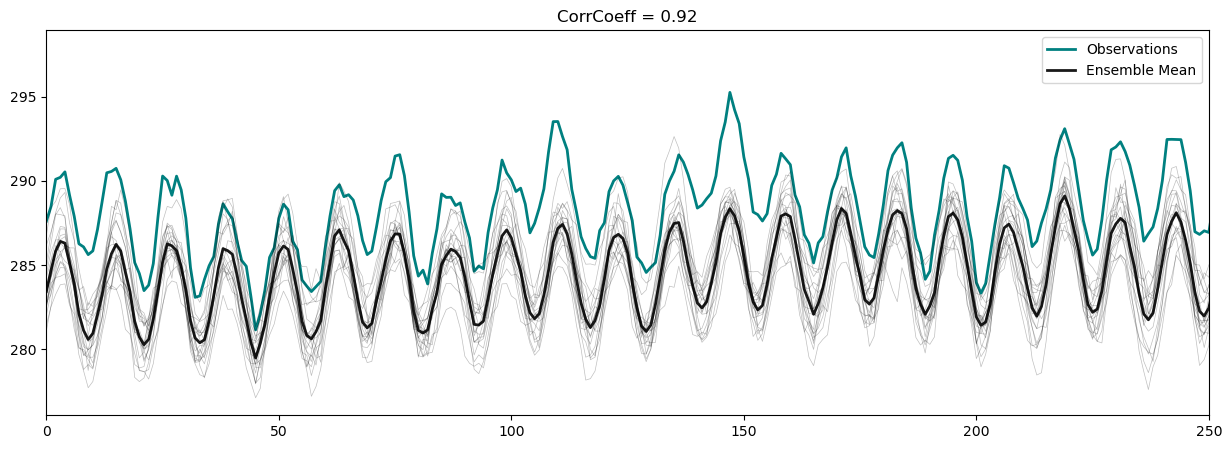

In [12]:
# Change these parameters to see how the Anomaly Correlation Coefficient (ACC)
# changes with different signal and noise variances.
# ------ MODIFY HERE ------
var_signal_obs, var_signal_ens = 1, 0.1
var_noise_obs, var_noise_ens = 1, 2
trend_obs, trend_ens = 0.01, 0.01
make_anomalies = False
# ------

Nsamples = 365*2
model_bias = -4
Nens = 20
tau = 10

# Create synthetic observational data
# signal_obs = create_rednoise(Nsamples, tau, var=var_signal_obs)
signal_obs = create_ensemble(Nsamples, tau, nens=1, var=var_signal_obs)
noise_obs = create_ensemble(Nsamples, tau, nens=1, var=var_noise_obs)
# noise_obs = create_rednoise(Nsamples, tau, var=var_noise_obs)
data_obs = add_seasonal_cycle(signal_obs + noise_obs)
data_obs = add_trend(data_obs, trend_obs)

# Create synthetic ensemble data
data_ens = (
    create_ensemble(Nsamples, tau, nens=Nens, var=var_noise_ens)
    + np.sqrt(var_signal_ens) * signal_obs
) + model_bias
data_ens = add_seasonal_cycle(data_ens)
data_ens = add_trend(data_ens, trend_ens)

# Remove seasonal cycle if desired
if make_anomalies:
    data_obs = remove_seasonal_cycle(data_obs)
    data_ens = remove_seasonal_cycle(data_ens)

# Compute correlation
rmo = np.corrcoef(data_ens.mean(axis=0), data_obs.mean(axis=0))[0, 1]

# Plot the observations, ensemble members, and ensemble mean
plt.figure(figsize=(15, 5))
plt.plot(data_obs.T, label="Observations", linewidth=2, color="teal")
plt.plot(data_ens.T, color="k", alpha=0.25, linewidth=0.5)
plt.plot(
    data_ens.mean(axis=0), label="Ensemble Mean", color="k", alpha=0.9, linewidth=2
)

plt.title(f"CorrCoeff = {rmo:.2f}")
plt.xlim(0, 250)
plt.legend()
plt.show()